# Replay based Class Incremental Learning (CIL) with PyTorch

This notebook covers a simplified implementation of class incremental learning (CIL) using replay-based techniques. The goal of CIL is to learn a model that can incrementally learn new classes without forgetting the previously learned classes. In this notebook, we will use a replay-based technique to store and replay the data from the previous classes to prevent forgetting.

To do this, we will use the following steps:
Train base model on the first set of two classes e.g. 0 and 1 for 100 epochs utilising Stochastic Gradient Descent (SGD) with a learning rate of 0.01 and momentum of 0.9.
After training our base model, we will then store a subset of our data from the first two classes in a replay buffer, let $R_i$ be the replay buffer for class $i$ and $D_i$ be the training data for class $i$ up to that training step inclusive of all previous classes.

We denote: $R_i \subseteq D_i$

And: $D_i = \cup_{x = 0}^{i}d_x$

Where $d_x$ is the data for class $x$.

i.e. the replay buffer will only contain a variant subset of the data from the previous classes as opposed to all the data of that class which
we can change to determine the effect of the replay buffer size on the model's performance.

From this point onwards, we will incrementally train our model utilising Class-Incremental Learning (CIL) by training on the class and replaying the data from the previous classes.

This model will utilise a standard implementation of a ResNet18 CNN model with a single fully connected layer at the end to classify the images. It will also be trained on the CIFAR-10 dataset, which contains 60,000 32x32 colour images in 10 classes, with 6,000 images per class.

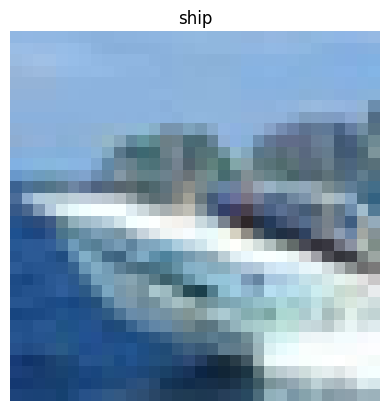

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes 
from torch.utils.data import DataLoader
import random

# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Define custom ResNet18 model for CIFAR10

In this case we chance the convolution kernel to 3x3 and the stride to 1 for the first layer. We will also change the number of classes on the final softmax layer to 10 to match the CIFAR10 dataset.

In [4]:
class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        print("|| conv1 weight size: ", self.resnet.conv1.weight.size())
        print("|| fc weight size: ", self.resnet.fc.weight.size())
        self.resnet.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(512, 10)
        # the architecture is already built to support 10 classes
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
# make a resnet model
model = ResNet18CIFAR()
model.eval()

|| conv1 weight size:  torch.Size([64, 3, 7, 7])
|| fc weight size:  torch.Size([1000, 512])


Using cache found in /dcs/21/u2145461/.cache/torch/hub/pytorch_vision_v0.10.0
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18CIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

### Data Load and Preprocessing into separate class datasets

Utilise the CIFAR-10 dataset alongside a prebuilt dataloader to load the data into separate class datasets.
(Krishi's code)

In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)


# The Algorithm

Train initial model on the first two classes.

For each class $i$ in the dataset:

1. Train the model on the current class $i$ and replay the data from the previous classes.

2. Store a subset of the data from the current class $i$ in the replay buffer $R_i$.

3. Evaluate the model on the test set.

4. Increment the number of classes seen.

5. Repeat steps 1-4 for each class in the dataset.

Note: the size of the replay buffer is a hyperparameter that can be tuned to determine the effect of the replay buffer size on the model's performance.

The following hyperparameters will be used in this notebook:

- Epochs: 100 (per class)
- Learning rate: 0.00005
- Momentum: 0.9 (if using SGD)
- Batch size: 512
- Replay buffer size: Variant (e.g. 1000, 2000, 3000, 4000, 5000 per class)

### References

1. [Continual Learning with Deep Architectures: A Review](https://arxiv.org/abs/1907.04471)

2. [RECALL Replay Based Continual Learning in Semantic Segmentation](https://openaccess.thecvf.com/content/ICCV2021/papers/Maracani_RECALL_Replay-Based_Continual_Learning_in_Semantic_Segmentation_ICCV_2021_paper.pdf)

In [6]:
def calculate_accuracy(model, accuracies, train_data, train_labels):
        # calculate accuracy
        correct = [0] * 10
        total = len(train_split['airplane'])
        batch_size = 64
        with torch.no_grad():
            for j in range(0, len(train_data), batch_size):
                image = train_data[j:j+batch_size]
                labels = train_labels[j:j+batch_size]
                outputs = model(image)
                _, predicted = torch.max(outputs.data, 1)
                for i in range(10):  
                    correct[i] += (predicted[labels == i] == labels[labels == i]).sum().item()
        
        j = 0
        accuracy_string = "Accuracy: "
        for classes in accuracies:
             accuracies[classes].append(correct[j]/total * 100)
             accuracy_string += (f"" + classes + f": {correct[j]/total * 100:.2f}%, ")
             j += 1

        return accuracy_string, accuracies

In [7]:
replay_memory = {cls: [] for cls in CLASSES}
accuracies = {cls: [] for cls in CLASSES}
learning_rate = 0.00005
momentum = 0.9
batch_size = 512
epochs = 100
loss_function = torch.nn.CrossEntropyLoss()
# output is softmax gaussian probability distribution, so cross entropy loss is appropriate
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []


# firstly, train on airplanes and automobiles for 100 epochs utilising Adam
current_train_data = train_split['airplane'] + train_split['automobile']
current_train_labels = [0] * len(train_split['airplane']) + [1] * len(train_split['automobile'])

# convert to tensors
current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()

# we have figured out CUDA for jupyter notebooks :)
for i in range(epochs):
    for j in range(0, len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        if (j == 0):
            losses.append(loss.item())
            accuracy_string, accuracies = calculate_accuracy(model, accuracies, train_data, train_labels)
            # calculate accuracy
            print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, " + accuracy_string)

/tmp/dcs-tmp.u2145461/ipykernel_181788/3759722728.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  current_train_data = torch.tensor(current_train_data).float()


Epoch 1/100, Loss: 0.02, Accuracy: airplane: 100.00%, automobile: 0.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 2/100, Loss: 734.32, Accuracy: airplane: 0.00%, automobile: 100.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 3/100, Loss: 14.22, Accuracy: airplane: 0.00%, automobile: 100.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 4/100, Loss: 2.57, Accuracy: airplane: 0.58%, automobile: 100.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 5/100, Loss: 1.05, Accuracy: airplane: 28.10%, automobile: 99.30%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 6/100, Loss: 0.85, Accuracy: airplane: 49.06%, automobile: 96.64%, bird: 0.00%, cat: 0.00%, deer: 0.0

### Initial Results for two classes

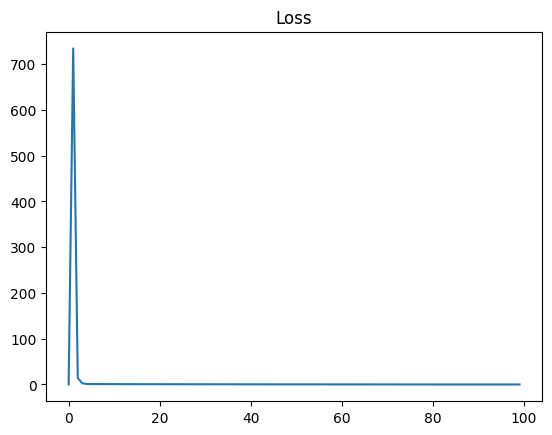

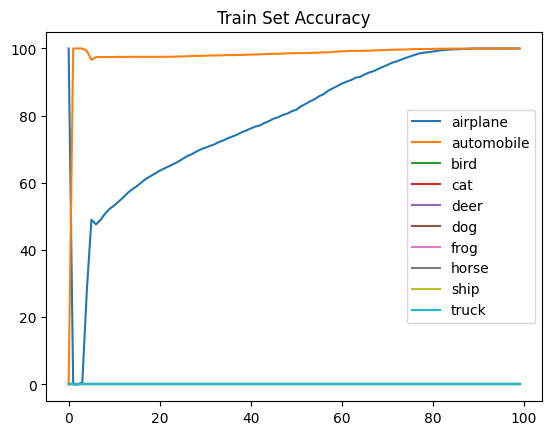

In [8]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies
for classes in accuracies:
    plt.plot(accuracies[classes], label=classes)
plt.title('Train Set Accuracy')
plt.legend()
plt.show()

## Now let's take the model and try to train it to identify birds!

For the first test we just assume that the replay buffer is just the all the data from the previous classes.
(we will adjust this later)

In fact, start off by just training the model on only birds to see the effects of catastrophic forgetting and how this can be mitigated.

In [9]:

current_train_data = train_split['bird']
current_train_labels =  [2] * len(train_split['bird'])

current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()

for i in range(epochs):
    for j in range(0, len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        if (j == 0):
            losses.append(loss.item())
            # calculate accuracy
            accuracy_string, accuracies = calculate_accuracy(model, accuracies, train_data, train_labels)
            print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, " + accuracy_string)


Epoch 1/100, Loss: 40.89, Accuracy: airplane: 99.50%, automobile: 100.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 2/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 3/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 4/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 5/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 6/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00

### Results for three classes: Catastrophic Forgetting

Notice we suffer from catastrophic forgetting when not taking into account a replay set. The model is unable to learn the new class without forgetting the previous classes.
This is as a result of the loss function being based simply to check the accuracy only on birds, which leads to the neural network defaulting to classifying every training example as birds to minimise loss only on birds.

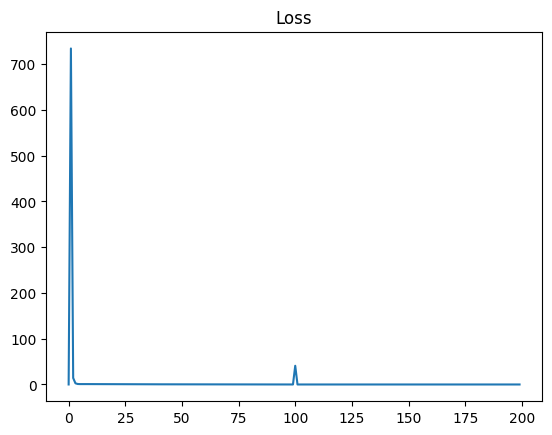

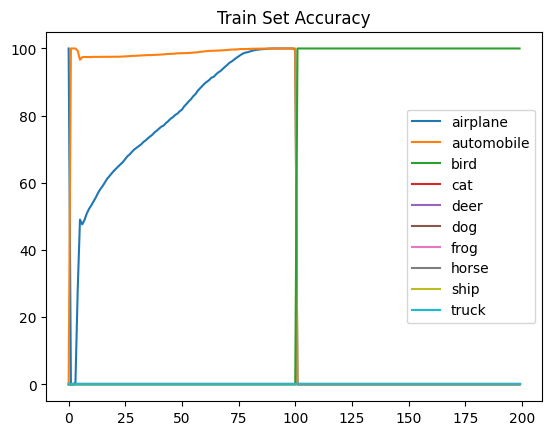

In [10]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies
for classes in accuracies:
    plt.plot(accuracies[classes], label=classes)
plt.title('Train Set Accuracy')
plt.legend()
plt.show()

In [11]:
# repeat this process for all classes
current_remaining_classes = CLASSES[3:] # cat, deer, dog, frog, horse, ship, truck

for current_class in current_remaining_classes:
    current_train_data = train_split[current_class]
    current_train_labels = [CLASSES.index(current_class)] * len(train_split[current_class])
    
    current_train_data = torch.tensor(current_train_data).float()
    current_train_labels = torch.tensor(current_train_labels)
    
    if torch.cuda.is_available():
        model = model.cuda()
        current_train_data = current_train_data.cuda()
        current_train_labels = current_train_labels.cuda()
    
    for i in range(epochs):
        for j in range(0, len(current_train_data), batch_size):
            optimiser.zero_grad()
            images = current_train_data[j:j+batch_size]
            labels = current_train_labels[j:j+batch_size]
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()
            if (j == 0):
                losses.append(loss.item())
                # calculate accuracy
                accuracy_string, accuracies = calculate_accuracy(model, accuracies, train_data, train_labels)
                if (i % 10 == 0):
                    print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, " + accuracy_string)

Epoch 1/100, Loss: 621.28, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 100.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 11/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 0.00%, cat: 100.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 21/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 0.00%, cat: 100.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 31/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 0.00%, cat: 100.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 41/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 0.00%, cat: 100.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 51/100, Loss: 0.00, Accuracy: airplane: 0.00%, automobile: 0.00%, bird: 0.00%, cat: 100.00%, deer:

# Results for Replay Buffer Size = 0

The model simply defaults to identifying all training examples to the data it is being trained on.

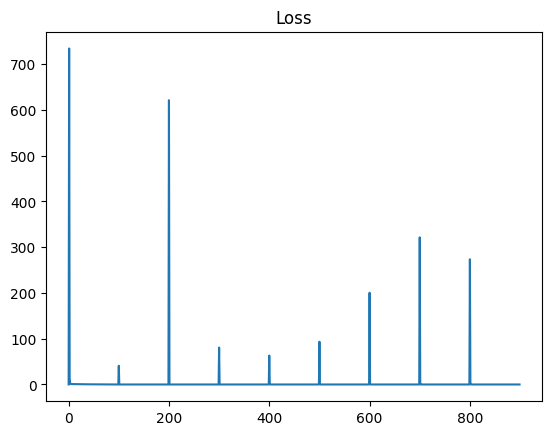

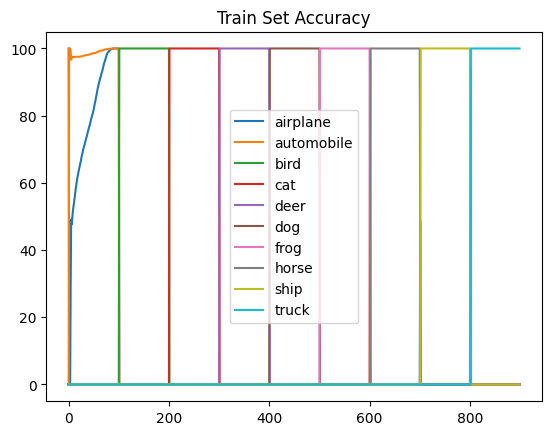

In [12]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies
for classes in accuracies:
    plt.plot(accuracies[classes], label=classes)
plt.title('Train Set Accuracy')
plt.legend()
plt.show()

# Set replay buffer size to 1000 (for each class)

We will randomly distill the replay buffer amongst each train set during each class incremental learning stage.

In [ ]:
# load the model before we trained on the 0 replay buffer sets
model = ResNet18CIFAR()
model.load_state_dict(torch.load('resnet18_cifar10_airplane_automobile.pth'))
model.eval()

current_remaining_classes = CLASSES[2:] # bird, cat, deer, dog, frog, horse, ship, truck

# increase learning rate
learning_rate = 0.00005
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

replay_buffer_size = 1000
replay_memory = []

# set accuracies back to the first 200
for cls in accuracies:
    accuracies[cls] = accuracies[cls][:100]

# generate replay buffer by randomly selecting 1000 images from each class
replay_memory += random.sample(train_split['airplane'], replay_buffer_size)
replay_memory += random.sample(train_split['automobile'], replay_buffer_size)

k = 2
current_retained_classes = [0, 1]  

for current_class in current_remaining_classes:
    current_train_data = train_split[current_class] + replay_memory
    current_train_labels = [CLASSES.index(current_class)] * len(train_split[current_class])
    
    for i in current_retained_classes:
        current_train_labels += [i] * replay_buffer_size
        
    current_retained_classes.append(k)
    k += 1
    
    # randomly shuffle the data
    
    # convert to image, label pairs
    zipped = list(zip(current_train_data, current_train_labels))
    # shuffle the pairs
    random.shuffle(zipped)
    # unzip the pairs back into lists
    current_train_data, current_train_labels = zip(*zipped)
    
    # convert to tensors
    current_train_data = torch.tensor(current_train_data).float()
    current_train_labels = torch.tensor(current_train_labels)
    
    # move to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        current_train_data = current_train_data.cuda()
        current_train_labels = current_train_labels.cuda()
    
    for i in range(epochs):
        for j in range(0, len(current_train_data), batch_size):
            optimiser.zero_grad()
            images = current_train_data[j:j+batch_size]
            labels = current_train_labels[j:j+batch_size]
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()
            if (j == 0):
                losses.append(loss.item())
                # calculate accuracy
                accuracy_string, accuracies = calculate_accuracy(model, accuracies, train_data, train_labels)
                if (i % 1 == 0):
                    print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, " + accuracy_string)
                
    # add the current class to the replay buffer
    replay_memory += random.sample(train_split[current_class], replay_buffer_size)

Using cache found in /dcs/21/u2145461/.cache/torch/hub/pytorch_vision_v0.10.0


|| conv1 weight size:  torch.Size([64, 3, 7, 7])
|| fc weight size:  torch.Size([1000, 512])
Epoch 1/100, Loss: 23.47, Accuracy: airplane: 99.38%, automobile: 100.00%, bird: 0.00%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 2/100, Loss: 0.84, Accuracy: airplane: 61.82%, automobile: 0.54%, bird: 80.70%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 3/100, Loss: 0.71, Accuracy: airplane: 0.12%, automobile: 24.12%, bird: 99.52%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 4/100, Loss: 0.56, Accuracy: airplane: 21.48%, automobile: 41.48%, bird: 95.50%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 5/100, Loss: 0.47, Accuracy: airplane: 44.50%, automobile: 60.36%, bird: 92.42%, cat: 0.00%, deer: 0.00%, dog: 0.00%, frog: 0.00%, horse: 0.00%, ship: 0.00%, truck: 0.00%, 
Epoch 6/100, 

# Results for Replay Buffer Size = 1000

Slightly less bad.

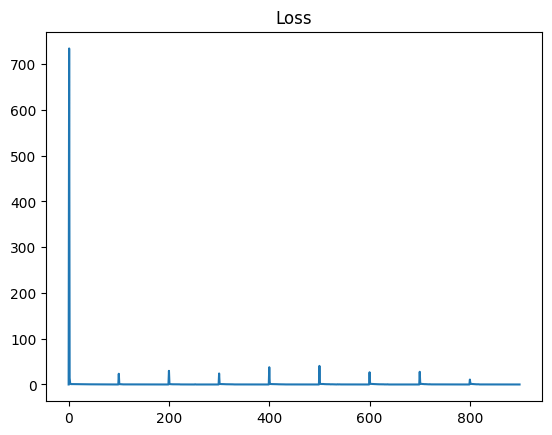

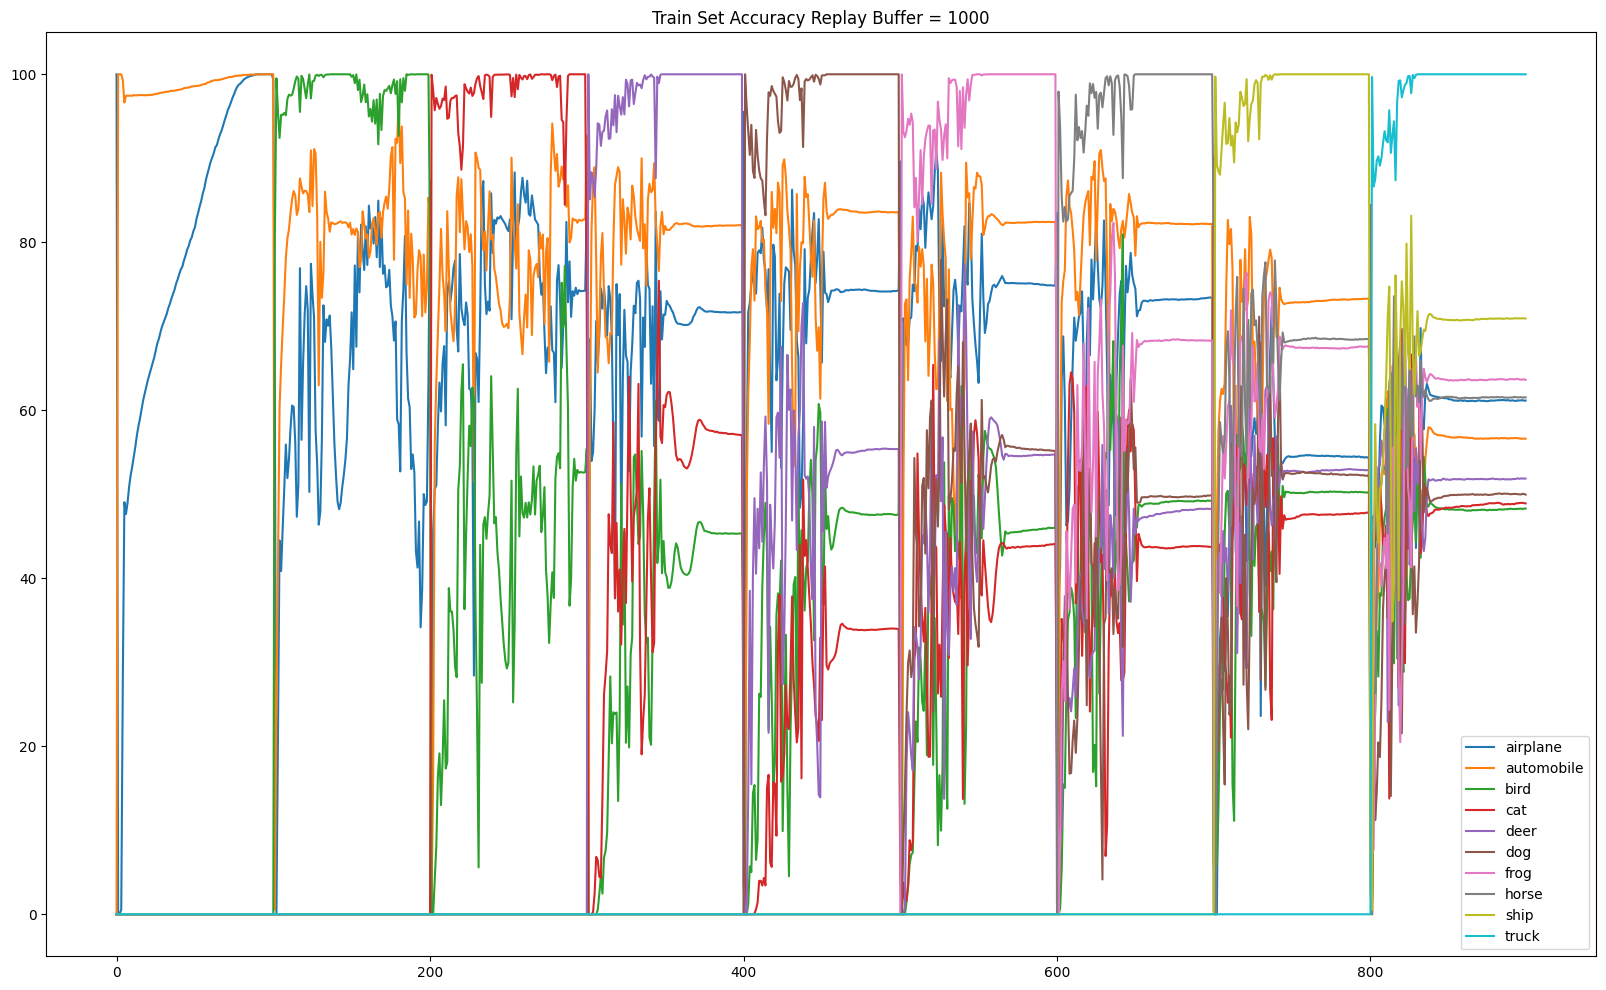

In [60]:
""" woopsies I accidentally deleted some results but uh good thing we printed the epoch accuracy!!!!
import re
 
# open results.csv file
with open('results.csv', 'r') as f:
    # for each line in the file check columns 2-11 and extract the accuracy ignore non numeric values
    for line in f:
        line = line.split(',')
        for i in range(2, 12):
            # regex [0-9]+.[0-9][0-9]+% to extract the accuracy
            accuracy = re.findall(r'[0-9]+.[0-9][0-9]+%', line[i])
            accuracies[CLASSES[i-2]].append(float(accuracy[0][:-1]))
"""
# plot the loss and accuracy
# fix axes labels

plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies

plt.figure(figsize=(20,12))
for classes in accuracies:

    plt.plot(accuracies[classes], label=classes)
plt.title('Train Set Accuracy Replay Buffer = 1000')
plt.legend()
plt.show()

In [ ]:
# load the model before we trained on the 0 replay buffer sets
model = ResNet18CIFAR()
model.load_state_dict(torch.load('resnet18_cifar10_airplane_automobile.pth'))
model.eval()

current_remaining_classes = CLASSES[2:] # bird, cat, deer, dog, frog, horse, ship, truck

# increase learning rate
learning_rate = 0.00005
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

replay_buffer_size = 2000
replay_memory = []

# set accuracies back to the first 200
for cls in accuracies:
    accuracies[cls] = accuracies[cls][:100]
    
losses = losses[:100]

# generate replay buffer by randomly selecting 1000 images from each class
replay_memory += random.sample(train_split['airplane'], replay_buffer_size)
replay_memory += random.sample(train_split['automobile'], replay_buffer_size)

k = 2
current_retained_classes = [0, 1]  

for current_class in current_remaining_classes:
    current_train_data = train_split[current_class] + replay_memory
    current_train_labels = [CLASSES.index(current_class)] * len(train_split[current_class])
    
    for i in current_retained_classes:
        current_train_labels += [i] * replay_buffer_size
        
    current_retained_classes.append(k)
    k += 1
    
    # randomly shuffle the data
    
    # convert to image, label pairs
    zipped = list(zip(current_train_data, current_train_labels))
    # shuffle the pairs
    random.shuffle(zipped)
    # unzip the pairs back into lists
    current_train_data, current_train_labels = zip(*zipped)
    
    # convert to tensors
    current_train_data = torch.tensor(current_train_data).float()
    current_train_labels = torch.tensor(current_train_labels)
    
    # move to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        current_train_data = current_train_data.cuda()
        current_train_labels = current_train_labels.cuda()
    
    for i in range(epochs):
        for j in range(0, len(current_train_data), batch_size):
            optimiser.zero_grad()
            images = current_train_data[j:j+batch_size]
            labels = current_train_labels[j:j+batch_size]
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()
            if (j == 0):
                losses.append(loss.item())
                # calculate accuracy
                accuracy_string, accuracies = calculate_accuracy(model, accuracies, train_data, train_labels)
                if (i % 1 == 0):
                    print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, " + accuracy_string)
                
    # add the current class to the replay buffer
    replay_memory += random.sample(train_split[current_class], replay_buffer_size)

In [ ]:
# plot the loss and accuracy
# fix axes labels

plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies

plt.figure(figsize=(20,12))
for classes in accuracies:

    plt.plot(accuracies[classes], label=classes)
plt.title('Train Set Accuracy Replay Buffer = 1000')
plt.legend()
plt.show()